In [1]:
!python --version

Python 3.10.13


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "notebook", "grid"])

## Load data

In [3]:
data = pd.read_csv('../data/data_diet_filtered.csv', index_col=0)
data.shape

/var/folders/qp/4w02sqhj6_d43815lhzjb7900000gn/T/ipykernel_72574/4102854965.py:1: DtypeWarning: Columns (756) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/data_diet_filtered.csv', index_col=0)


(14560, 756)

In [4]:
data.head()

,index,s__Abiotrophia_defectiva,s__Abiotrophia_sp_HMSC24B09,s__Absiella_dolichum,s__Achromobacter_xylosoxidans,s__Acidaminococcus_fermentans,s__Acidaminococcus_intestini,s__Acidaminococcus_sp_CAG_542,s__Acinetobacter_johnsonii,s__Actinobaculum_sp_oral_taxon_183,...,s__Victivallis_vadensis,s__Weissella_cibaria,s__Weissella_confusa,s__Weissella_viridescens,subject_id,disease,country,gender,age_category,diet
0,D_1118_R4_010202,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0000,...,0.0,0.0000,0.00000,0.0,D_1118_R4_010202,healthy,ITA,NaN,adult,NaN
1,D_2646_R5_290108,0.0,0.0,0.0,0.0,0.0,0.01194,0.0,0.0,0.0028,...,0.0,0.0005,0.00000,0.0,D_2646_R5_290108,healthy,ITA,NaN,adult,NaN
2,D_3185_R2_160304,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0000,...,0.0,0.0000,0.00000,0.0,D_3185_R2_160304,healthy,ITA,NaN,adult,NaN
3,D_3313_R0_230300,0.0,0.0,0.0,0.0,0.0,0.02064,0.0,0.0,0.0000,...,0.0,0.0000,0.00000,0.0,D_3313_R0_230300,healthy,ITA,NaN,adult,NaN
4,D_5120_R1_200409-R4_041017,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0000,...,0.0,0.0000,0.01015,0.0,D_5120_R1_200409-R4_041017,healthy,ITA,NaN,adult,NaN


In [5]:
all_features = data.columns
# all the columns that start with 's__' are a bacterium
print(f"Features which are NOT bacterial relative abundance are: ")
print([f for f in all_features if not f.startswith('s__')])

Features which are NOT bacterial relative abundance are: 
['index', 'subject_id', 'disease', 'country', 'gender', 'age_category', 'diet']


## Plot class distribution

In [6]:
def plot_class_distribution(data: pd.DataFrame, savefigpath=None, show=True):
    
    # 5 disease classes are there in our data
    my_colors = ['green', 'blue', 'red', 'tomato', 'sienna']
    ax = data.disease.value_counts(sort=False).plot(kind='bar',
                                                title='#samples (individuals) per disease category',
                                                color=my_colors
                                               )
    # annotate the actual number on top of the bars
    values = data.disease.value_counts(sort=False).to_dict()
    for i, key in enumerate(values):
        ax.text(i, values[key]+100, f'{values[key]}', ha='center', fontsize='large')
    
    if savefigpath:
        plt.savefig(savefigpath)
    
    if show:
        plt.show()

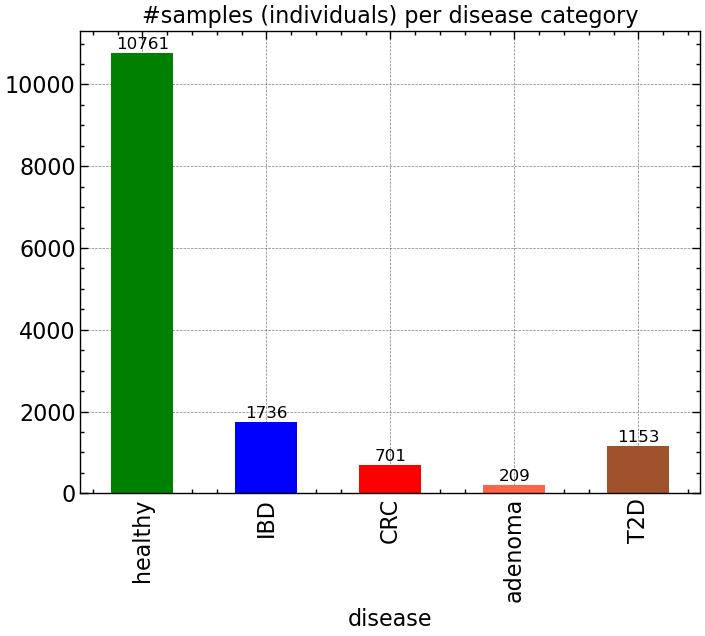

In [7]:
plot_class_distribution(data)

## Sparsity visualisation

There are few rows in the original dataframe that have 0, 1, 2, i.e., very few 
non-zero columns!

In [8]:
data.disease, enc_values = pd.factorize(data.disease) # to get back original labels, do "enc_values[data.disease]"

# remove non-relative-abundance columns
drop_col = ['index', 'disease', 'subject_id','gender', 'country','age_category', 'diet']
X = data.drop(labels=drop_col, axis=1)
y = data.disease.values

class_map = {v: k for v, k in enumerate(list(enc_values.values))}
print(class_map)

{0: 'healthy', 1: 'IBD', 2: 'CRC', 3: 'adenoma', 4: 'T2D'}


In [9]:
def smooth(y, box_pts=5):
    # running average to smoothen out curves
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_sparsity_distribution(data: pd.DataFrame,
                               class_map,
                               smooth_box=15,
                               savefigpath=None, show=True):
    
    # add a dummy feature to store number of non-zero bacteria/columns in a row
    data['nonzero'] = (X > 0).sum(1)
    # create a temporary df to store disease id, nonzero columns, and count of such rows
    df = data.groupby(['disease', 'nonzero'])['disease'].value_counts().reset_index()
    
    colors = {0: 'green',
          1: 'blue',
          2: 'red',
          3: 'tomato',
          4: 'sienna'}
    
    for disease_no in range(5):
        # print(disease_no, class_map[disease_no])
        
        xaxis = df[df.disease==disease_no]['nonzero']
        yaxis = smooth(df[df.disease==disease_no]['count'] / df[df.disease==disease_no]['count'].sum(), smooth_box)
        
        plt.plot(xaxis, yaxis, color=colors[disease_no], label=class_map[disease_no])
        
    plt.xlim(0, 201)
    plt.ylim(0, 0.04)
    plt.xlabel('Total number (non-zero) bacteria species present')
    plt.ylabel('Fraction of individuals')
    plt.legend()
    plt.title('Distribution of samples based on number of\nnon-zero species (normalized and smoothed) per disease')
    
    if savefigpath:
        plt.savefig(savefigpath)
    
    if show:
        plt.show()

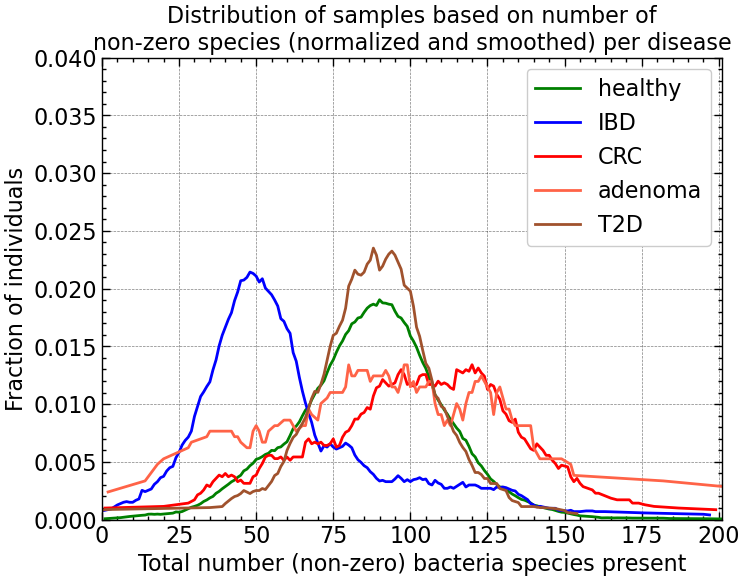

In [10]:
plot_sparsity_distribution(data, class_map, smooth_box=10)

## The above plot shows the following:
- Each point on x-axis represents the number of non-zero columns that could be present in a row of the dataframe.
- The corresponding point on y-axis represents how many individuals/rows (belonging to that disease category) have those many non-zero columns.
- Overall we see patients with IBD tend to have sparser microbiome than others.